<a href="https://colab.research.google.com/github/miu0001/Statistical_Inference/blob/master/6.5%20A_Simple_Linear_Regression_Problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
# === Required packages ===
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import f as fdist

Simple Linear Regression

In [23]:
def fit_simple_lr(x, y, alpha: float = 0.05, robust: str | None = None):
    """
    Fit simple linear regression y ~ const + x and return:
      - coeff_table: DataFrame of coef, std_err, p_value, CIs
      - results: statsmodels OLSResults object (for ANOVA, diagnostics, etc.)
    """
    x = np.asarray(x, dtype=float).ravel()
    y = np.asarray(y, dtype=float).ravel()
    if x.shape[0] != y.shape[0]:
        raise ValueError("x and y must have the same number of observations.")

    X = sm.add_constant(x, has_constant="add")
    model = sm.OLS(y, X)
    results = model.fit() if robust is None else model.fit(cov_type=robust)

    ci = results.conf_int(alpha=alpha)
    ci_cols = [f"ci_lower_{1-alpha:.0%}", f"ci_upper_{1-alpha:.0%}"]
    ci_df = pd.DataFrame(ci, columns=ci_cols)
    ci_df.index = ["const", "x"]

    coeff_table = pd.DataFrame({
        "coef": results.params,
        "std_err": results.bse,
        "p_value": results.pvalues
    }, index=["const", "x"]).join(ci_df)

    return coeff_table, results


Anova Table

In [29]:
from scipy.stats import f as fdist

def anova_from_results(results, append_sigma_rows: bool = True) -> pd.DataFrame:
    """
    Classic ANOVA (Regression vs Residual) from a statsmodels OLSResults object.
    Optionally appends rows for sigma^2 (MSE) and sigma (Residual Std. Error).
    """
    # Sums of squares
    SSR = float(results.ess)             # Regression sum of squares
    SSE = float(results.ssr)             # Error (residual) sum of squares
    SST = float(results.centered_tss)    # Total sum of squares

    # Degrees of freedom
    df_reg = int(results.df_model)       # number of predictors (excl. intercept)
    df_res = int(results.df_resid)
    df_tot = df_reg + df_res

    # Mean squares
    MSR = SSR / df_reg if df_reg > 0 else np.nan
    MSE = SSE / df_res if df_res > 0 else np.nan

    # F-statistic and p-value
    F = MSR / MSE if (df_reg > 0 and df_res > 0) else np.nan
    pval = fdist.sf(F, df_reg, df_res) if np.isfinite(F) else np.nan

    # Base ANOVA table
    tbl = pd.DataFrame(
        {
            "SS":     [SSR, SSE, SST],
            "df":     [df_reg, df_res, df_tot],
            "MS":     [MSR, MSE, np.nan],
            "F":      [F,   np.nan, np.nan],
            "PR(>F)": [pval, np.nan, np.nan],
        },
        index=["Regression", "Residual", "Total"]
    )

    # Append sigma^2 and sigma (as extra rows with MS populated)
    if append_sigma_rows:
        sigma2 = MSE
        sigma = np.sqrt(MSE) if np.isfinite(MSE) else np.nan
        extra = pd.DataFrame(
            {
                "SS":     [np.nan, np.nan],
                "df":     [np.nan, np.nan],
                "MS":     [sigma2, sigma],
                "F":      [np.nan, np.nan],
                "PR(>F)": [np.nan, np.nan],
            },
            index=[r"$\hat{\sigma}^2$ (MSE)", r"$\hat{\sigma}$ (RSE)"]
        )
        tbl = pd.concat([tbl, extra], axis=0)

    return tbl


Example 1

Create a scatterplot

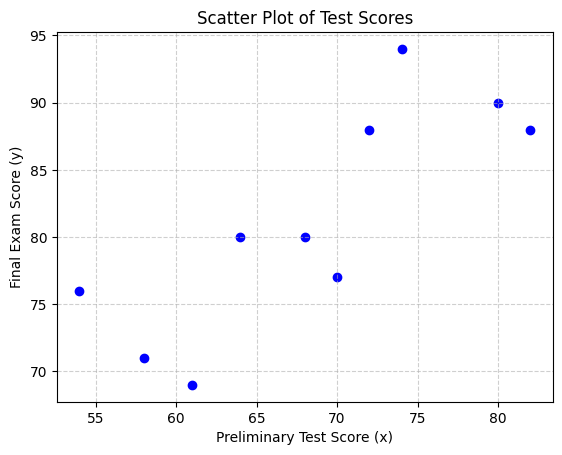

In [32]:
x = [70, 74, 72, 68, 58, 54, 82, 64, 80, 61]
y = [77, 94, 88, 80, 71, 76, 88, 80, 90, 69]

# Scatter plot
plt.scatter(x, y, color="blue", marker="o")
plt.xlabel("Preliminary Test Score (x)")
plt.ylabel("Final Exam Score (y)")
plt.title("Scatter Plot of Test Scores")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

In [33]:
x = [70, 74, 72, 68, 58, 54, 82, 64, 80, 61]
y = [77, 94, 88, 80, 71, 76, 88, 80, 90, 69]

coeff_table, results = fit_simple_lr(x, y, alpha=0.05, robust=None)

print("== Coefficient Table ==")
print(coeff_table.round(4))

print("\n== ANOVA Table ==")
print(anova_from_results(results).round(4))

== Coefficient Table ==
          coef  std_err  p_value  ci_lower_95%  ci_upper_95%
const  30.6147  13.0622   0.0471        0.4933       60.7362
x       0.7421   0.1897   0.0045        0.3046        1.1796

== ANOVA Table ==
                             SS   df        MS        F  PR(>F)
Regression              416.391  1.0  416.3910  15.3008  0.0045
Residual                217.709  8.0   27.2136      NaN     NaN
Total                   634.100  9.0       NaN      NaN     NaN
$\hat{\sigma}^2$ (MSE)      NaN  NaN   27.2136      NaN     NaN
$\hat{\sigma}$ (RSE)        NaN  NaN    5.2167      NaN     NaN


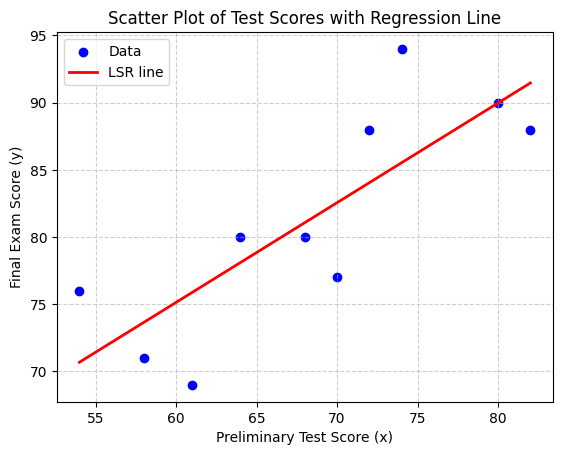

In [37]:
# Fit regression
X = sm.add_constant(x)
model = sm.OLS(y, X).fit()

# Line points
x_line = np.linspace(x.min(), x.max(), 200)
X_line = sm.add_constant(x_line)
y_line = model.predict(X_line)

# Scatter + regression line
plt.scatter(x, y, color="blue", marker="o", label="Data")
plt.plot(x_line, y_line, color="red", linewidth=2, label="LSR line")
plt.xlabel("Preliminary Test Score (x)")
plt.ylabel("Final Exam Score (y)")
plt.title("Scatter Plot of Test Scores with Regression Line")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()